# Recurrent Neural Net with Embeddings
Adapted from: https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py

Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually **too small for LSTM** to be of any advantage
compared to simpler, much faster methods such as TF-IDF + Logistic Regression.
### Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.

In [8]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

max_num_words = 10000
maxlen = 80
batch_size = 32
embedding_dims = 50
hidden_dims = 250
epochs = 2

# Sentiment Analysis
With Sentiment Analysis, we want to determine the attitude (e.g the sentiment) of for example a speaker or writer with respect to a document, interaction, or event. Therefore it is a natural language processing problem where text needs to be understood, to predict the underlying intent. The sentiment is mostly categorized into positive, negative and neutral categories. With the use of Sentiment Analysis, we want to predict for example a customers opinion and attitude about a product based on a review he wrote about it. Because of that, Sentiment Analysis is widely applied to things like reviews, surveys, documents and much more.

# The Imdb Dataset
The imdb sentiment classification dataset consists of 50,000 movie reviews from imdb users that are labeled as either positive (1) or negative (0). The reviews are preprocessed and each one is encoded as a sequence of word indexes in the form of integers. The words within the reviews are indexed by their overall frequency within the dataset. For example, the integer “2” encodes the second most frequent word in the data. The 50,000 reviews are split into 25,000 for training and 25,000 for testing. The dataset was created by researchers of the Stanford University and published in a [paper in 2011](http://www.aclweb.org/anthology/P11-1015), where they achieved 88.89% accuracy. It was also used within the “Bag of Words Meets Bags of Popcorn” Kaggle competition in 2011.

In [9]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_num_words)

Loading data...


## Explore the Data

In [10]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

import numpy as np

print("Categories:", np.unique(y_train))
print("Number of unique words:", len(np.unique(np.hstack(x_train))))
length = [len(i) for i in x_train]
print("Average Review length:", np.mean(length))
print("Standard Deviation:", round(np.std(length)))

25000 train sequences
25000 test sequences
Categories: [0 1]
Number of unique words: 9998
Average Review length: 238.71364
Standard Deviation: 176


The output shows that the dataset is labeled into two categories, either 0 or 1, which represent the sentiment of the review. The whole dataset contains 9998 unique words and the average review length is 234 words, with a standard deviation of 173 words.

Now we will look at a single training example:

In [11]:
print("Label:", y_train[0])
print(x_train[0])

Label: 1
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The first review of the dataset is labeled as positive (1).
The function `get_word_index()` retrieves the dictionary mapping words to indices. We invert the index so that we can get back the original words and we can read them. Unknown words are replaced with a “#”.

`get_words_index()` starts numbering from 3.

In [12]:
index = imdb.get_word_index()

word_index = { w:(k+3) for w,k in index.items() if k < max_num_words}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2

# Data Preparation

Pad the sequences so that they have all the same length.

In [13]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


# Build the Model
We can now build our simple Neural Network. We start by defining the type of model we want to build. There are two types of models available in Keras: the Sequential model and the Model class used with functional API.

Then we simply add the input-, hidden- and output-layers.
The input layer is an embedding layer, used to represent each word as a vector in a space of dimensions `hidden_dims`.

The first hidden layer is an `LSTM` layer, to which we add a dropout to prevent overfitting.
Note that you should always use a dropout rate between 20% and 50%.

At the output layer, we use a Dense layer with the sigmoid as activation function, which maps the values between 0 and 1.

In [14]:
model = Sequential()
model.add(Embedding(max_num_words, embedding_dims))
model.add(LSTM(hidden_dims, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Show the model we have just built.

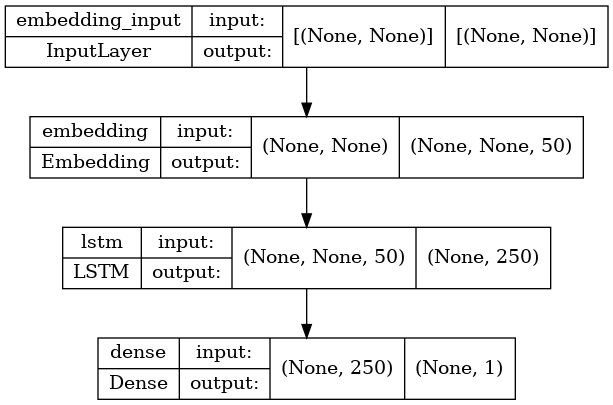

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Train the Model
We are now able to train our model. We do this with a batch_size of 32 and only for two epochs because I recognized that the model overfits if we train it longer.

The Batch size defines the number of samples that will be propagated through the network and an epoch is an iteration over the entire training data. In general a larger batch-size results in faster training, but don’t always converges fast. A smaller batch-size is slower in training but it can converge faster.

This is definitely problem dependent and you need to try out a few different values. If you start with a problem for the first time, I would you recommend to you to first use a batch-size of 32, which is the standard size.

In [19]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)
print('Train accuracy', np.mean(history.history["val_accuracy"]))

Epoch 1/2
704/704 [==============================] - 189s 265ms/step - loss: 0.4571 - accuracy: 0.7788 - val_loss: 0.3738 - val_accuracy: 0.8352
Epoch 2/2
704/704 [==============================] - 187s 265ms/step - loss: 0.3000 - accuracy: 0.8749 - val_loss: 0.3979 - val_accuracy: 0.8288
Train accuracy 0.8320000171661377


## Evaluate the Model

In [37]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 139s 6ms/step
Test score: 0.44111163621902466
Test accuracy: 0.8271600008010864


# Bidirectional LSTM

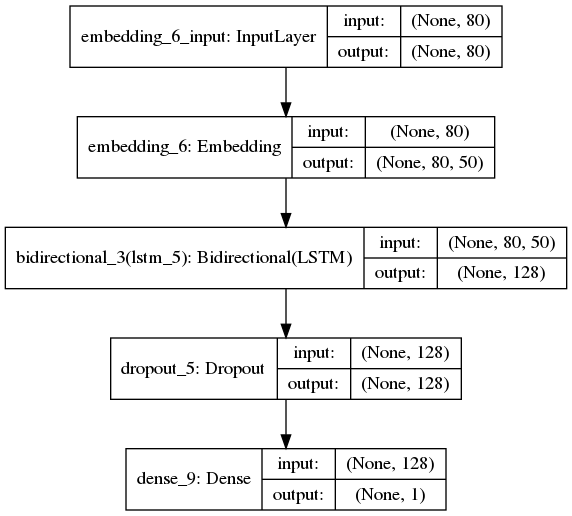

In [38]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(max_num_words, embedding_dims, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

plot_model(model, show_shapes=True)

In [39]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)
print('Train accuracy', np.mean(history.history["val_accuracy"]))

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 148s 7ms/step - loss: 0.4402 - accuracy: 0.7861 - val_loss: 0.3617 - val_accuracy: 0.8388
Epoch 2/2
22500/22500 [==============================] - 148s 7ms/step - loss: 0.2751 - accuracy: 0.8885 - val_loss: 0.3664 - val_accuracy: 0.8392
Train accuracy 0.839000016450882


## Evaluate model

In [41]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 69s 3ms/step
Test score: 0.37134366543769837
Test accuracy: 0.8381999731063843


# One-hot Model

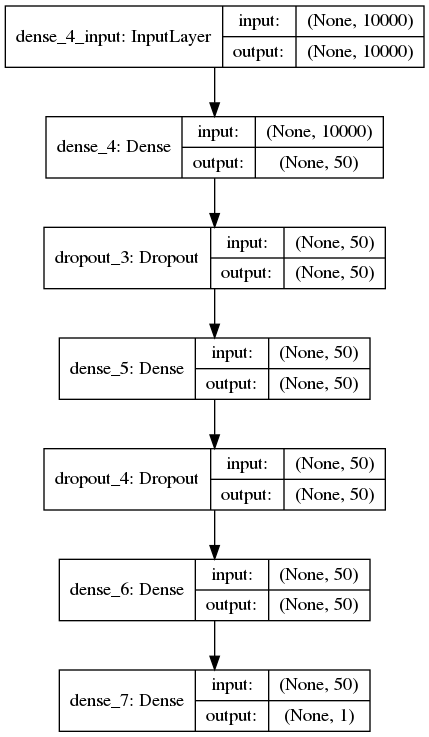

In [18]:
def vectorize(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] += 1
    return results
 
vdata = vectorize(data)
targets = np.array(targets).astype("float32")

test_x = vdata[:10000]
test_y = targets[:10000]
train_x = vdata[10000:]
train_y = targets[10000:]

model = Sequential()
model.add(Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - Layers
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
# Output- Layer
model.add(Dense(1, activation = "sigmoid"))

plot_model(model, show_shapes=True)

## Train the model

In [26]:
vdata[0][14]

1.0

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_x, train_y,
     epochs= 2,
     batch_size = 500,
     validation_split = 0.1
)
print("Train Accuracy:", np.mean(history.history["val_accuracy"]))

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 8s 207us/step - loss: 0.4180 - accuracy: 0.8119 - val_loss: 0.2643 - val_accuracy: 0.8930
Epoch 2/2
40000/40000 [==============================] - 8s 204us/step - loss: 0.2181 - accuracy: 0.9176 - val_loss: 0.2657 - val_accuracy: 0.8945
Train Accuracy: 0.893750011920929


With this simple model, we already beat the accuracy of the 2011 paper mentioned st the beginning.
Feel free to experiment with the hyperparameters and the number of layers.